# Log Gaussian Cox process

In [1]:
import matplotlib as mpl; mpl.use('pgf')

In [2]:
%matplotlib inline

In [3]:
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from collections import defaultdict

from sklearn.preprocessing import MinMaxScaler
from matplotlib import animation
from IPython.display import HTML

from etudes.gaussian_processes import gp_sample_custom, dataframe_from_gp_samples

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
golden_ratio = 0.5 * (1 + np.sqrt(5))
golden_size = lambda width: (width, width / golden_ratio)

In [5]:
width = 10

rc = {
    "figure.figsize": golden_size(width),
    "text.usetex": True,
}

sns.set(context="notebook", style="ticks", palette="colorblind", font="serif", rc=rc)

In [6]:
data = pd.read_csv("../../datasets/coal-mining-disasters/data.csv", 
                   names=["count", "days"], header=None, index_col=1)
data

,count
days,
25.5,1
75.5,0
125.5,0
175.5,1
225.5,0
...,...
40326.0,0
40376.0,0
40426.0,0


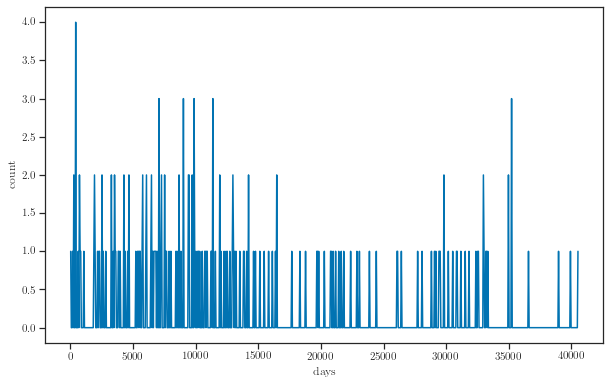

In [7]:
fig, ax = plt.subplots()

sns.lineplot(x="days", y="count", data=data.reset_index(), ax=ax)

plt.show()

In [8]:
# shortcuts
tfd = tfp.distributions
kernels = tfp.math.psd_kernels

# constants
n_features = 1 # dimensionality

n_samples = 20 # nbr of GP prior samples
jitter = 1e-6
kernel_cls = kernels.MaternOneHalves

n_train, num_features = data.shape

n_index_points = 256
n_inducing_points = 50
n_epochs = 2000
batch_size = 64
quadrature_size = 20

seed = 888 # set random seed for reproducibility
random_state = np.random.RandomState(seed)

x_min, x_max = 0, 1
y_min, y_max = -4.0, 4.0
x_loc = -0.5
# index points
X_q = np.linspace(-0.5, 1.5, n_index_points).reshape(-1, num_features)

AttributeError: module 'tensorflow_probability.python.math.psd_kernels' has no attribute 'MaternOneHalves'

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X = scaler.fit_transform(data.index.to_numpy().reshape(-1, num_features))
X.shape

In [ ]:
Y = data.to_numpy().squeeze().astype("float64")
Y.shape

In [ ]:
fig, ax = plt.subplots()

ax.plot(X, Y)

ax.set_xlabel('days (since March 15, 1851)')
ax.set_ylabel('coal mine disasters')

plt.show()

In [ ]:
amplitude = tf.exp(tf.Variable(np.float64(0)), name='amplitude')
length_scale = tf.exp(tf.Variable(np.float64(-1)), name='length_scale')
observation_noise_variance = tf.exp(tf.Variable(np.float64(-5)), name='observation_noise_variance')
kernel = kernel_cls(amplitude=amplitude, length_scale=length_scale)

In [ ]:
inducing_index_points_initial = random_state.choice(X.squeeze(), n_inducing_points).reshape(-1, n_features)
inducing_index_points_initial.shape

In [ ]:
inducing_index_points = tf.Variable(inducing_index_points_initial, 
                                    name='inducing_index_points')
variational_inducing_observations_loc = tf.Variable(np.zeros(n_inducing_points), 
                                                    name='variational_inducing_observations_loc')
variational_inducing_observations_scale = tf.Variable(
    np.eye(n_inducing_points), name='variational_inducing_observations_scale')

In [ ]:
vgp = tfd.VariationalGaussianProcess(
    kernel=kernel,
    index_points=X_q,
    inducing_index_points=inducing_index_points,
    variational_inducing_observations_loc=variational_inducing_observations_loc,
    variational_inducing_observations_scale=variational_inducing_observations_scale,
    observation_noise_variance=observation_noise_variance
)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X, Y)) \
                         .shuffle(buffer_size=500, seed=seed) \
                         .batch(batch_size, drop_remainder=True)
iterator = tf.data.make_initializable_iterator(dataset)
X_batch, Y_batch = iterator.get_next()
X_batch, Y_batch

In [ ]:
log_mean_offset = tf.Variable(np.float64(1.0), name='log_mean_offset')
log_mean_offset

In [ ]:
def make_likelihood(f, log_mean_offset):

    return tfd.Independent(tfd.Poisson(log_rate=f + log_mean_offset),
                           reinterpreted_batch_ndims=1)

In [ ]:
vgp_sample = vgp.sample()
vgp_sample

In [ ]:
model_sample = make_likelihood(vgp_sample, log_mean_offset).mean()
model_sample

In [ ]:
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    vgpmodel_sample_value = sess.run(model_sample)

In [ ]:
fig, ax = plt.subplots()

ax.plot(X_q, vgpmodel_sample_value.T, alpha=0.4)

plt.show()

In [ ]:
def log_likelihood(Y, f):

    p = make_likelihood(f, log_mean_offset)
    return p.log_prob(Y)

In [ ]:
ell = vgp.surrogate_posterior_expected_log_likelihood(
    observation_index_points=X_batch,
    observations=Y_batch,
    log_likelihood_fn=log_likelihood,
    quadrature_size=quadrature_size
)
ell

In [ ]:
kl = vgp.surrogate_posterior_kl_divergence_prior()
kl

In [ ]:
nelbo = - ell + kl * batch_size / n_train
nelbo

In [ ]:
optimizer = tf.train.AdamOptimizer()
optimize = optimizer.minimize(nelbo)

In [ ]:
steps_per_epoch = n_train // batch_size
steps_per_epoch

In [ ]:
history = defaultdict(list)

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    for i in range(n_epochs):

        print(i)
        sess.run(iterator.initializer)
        
        for j in range(steps_per_epoch):

            (_, nelbo_value, 
             amplitude_value, 
             length_scale_value,
             observation_noise_variance_value,
             inducing_index_points_value,
             variational_inducing_observations_loc_value,
             variational_inducing_observations_scale_value,
             log_mean_offset_value) = sess.run([optimize, 
                                                nelbo, 
                                                amplitude, 
                                                length_scale, 
                                                observation_noise_variance,
                                                inducing_index_points,
                                                variational_inducing_observations_loc, 
                                                variational_inducing_observations_scale,
                                                log_mean_offset])

        history["nelbo"].append(nelbo_value)
        history["amplitude"].append(amplitude_value)
        history["length_scale"].append(length_scale_value)
        history["observation_noise_variance"].append(observation_noise_variance_value)
        history["inducing_index_points"].append(inducing_index_points_value)
        history["variational_inducing_observations_loc"].append(variational_inducing_observations_loc_value)
        history["variational_inducing_observations_scale"].append(variational_inducing_observations_scale_value)
        history["log_mean_offset"].append(log_mean_offset_value)

In [ ]:
history_df = pd.DataFrame(history)

In [ ]:
fig, ax = plt.subplots()

sns.lineplot(x='index', y='amplitude', data=history_df.reset_index(),
             alpha=0.8, ax=ax)

ax.set_xlabel("epoch")
ax.set_yscale("log")

plt.show()

In [ ]:
inducing_index_points_history = np.stack(history["inducing_index_points"])
inducing_index_points_history.shape

In [ ]:
segments_min_history = np.dstack(np.broadcast_arrays(inducing_index_points_history, y_min))
segments_max_history = np.dstack([inducing_index_points_history, 
                                  history["variational_inducing_observations_loc"]])

In [ ]:
segments_history = np.stack([segments_max_history, segments_min_history], axis=-2)
segments_history.shape

In [ ]:
kernel_history = kernel_cls(amplitude=history.get("amplitude"), length_scale=history.get("length_scale"))

vgp_history = tfd.VariationalGaussianProcess(
    kernel=kernel_history,
    index_points=X_q,
    inducing_index_points=np.stack(history.get("inducing_index_points")),
    variational_inducing_observations_loc=np.stack(history.get("variational_inducing_observations_loc")),
    variational_inducing_observations_scale=np.stack(history.get("variational_inducing_observations_scale")),
    observation_noise_variance=history.get("observation_noise_variance")
)
vgp_mean = vgp_history.mean()
vgp_stddev = vgp_history.stddev()

In [ ]:
with tf.Session() as sess:
    vgp_mean_value, vgp_stddev_value = sess.run([vgp_mean, vgp_stddev])

In [ ]:
fig, ax = plt.subplots()

# ax.plot(X_q, latent_true, 'k-', label=r"$\log p(x) - \log q(x)$")

ax.plot(X_q, vgp_mean_value[-1], label="posterior predictive mean")
ax.fill_between(np.squeeze(X_q), 
                vgp_mean_value[-1] - 2*vgp_stddev_value[-1], 
                vgp_mean_value[-1] + 2*vgp_stddev_value[-1], alpha=0.1)

# ax.scatter(X, Y, marker='x', color='k', label="noisy observations")

ax.vlines(history["inducing_index_points"][-1], ymin=y_min, 
          ymax=history["variational_inducing_observations_loc"][-1],
          color='k', linewidth=1.0, alpha=0.4)

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.set_ylim(y_min, y_max)

ax.legend()

plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw=dict(hspace=0.1))

# ax1.plot(X_q, latent_true, 'k-', label=r"$\log p(x) - \log q(x)$")

line_mean, = ax1.plot(X_q, vgp_mean_value[-1], color="tab:blue", label="posterior predictive mean")
line_stddev_lower, = ax1.plot(X_q, vgp_mean_value[-1] - 2*vgp_stddev_value[-1], 
                              color="tab:blue", alpha=0.4)
line_stddev_upper, = ax1.plot(X_q, vgp_mean_value[-1] + 2*vgp_stddev_value[-1],
                              color="tab:blue", alpha=0.4)

vlines_inducing_index_points = ax1.vlines(inducing_index_points_history[-1].squeeze(), 
                                          ymax=history["variational_inducing_observations_loc"][-1],
                                          ymin=y_min, linewidth=1.0, alpha=0.4)

ax1.set_ylabel('$\log \lambda(x)$')
ax1.set_ylim(y_min, y_max)

lines_inducing_index_points = ax2.plot(inducing_index_points_history.squeeze(), range(n_epochs),
                                       color='k', linewidth=1.0, alpha=0.4)

ax2.set_xlabel(r"$x$")
ax2.set_ylabel("epoch")

ax1.legend()

plt.show()

In [ ]:
# # num_frames = 100
# num_frames = n_epochs

In [ ]:
# def animate(i):

#     line_mean.set_data(X_q, vgp_mean_value[-num_frames+i])
#     line_stddev_lower.set_data(X_q, vgp_mean_value[-num_frames+i] - 2*vgp_stddev_value[-num_frames+i])
#     line_stddev_upper.set_data(X_q, vgp_mean_value[-num_frames+i] + 2*vgp_stddev_value[-num_frames+i])

#     vlines_inducing_index_points.set_segments(segments_history[-num_frames+i])

#     for j, line in enumerate(lines_inducing_index_points):
#         line.set_data(inducing_index_points_history[:-num_frames+i, j], 
#                       np.arange(n_epochs-num_frames+i))

#     ax2.relim()
#     ax2.autoscale_view(scalex=False)

#     return lines_inducing_index_points + [line_mean, line_stddev_lower, line_stddev_upper]

In [ ]:
# anim = animation.FuncAnimation(fig, animate, frames=num_frames,
#                                interval=60, repeat_delay=5, blit=True)

In [ ]:
# HTML(anim.to_html5_video())

In [ ]:
kernel_final = kernel_cls(amplitude=history["amplitude"][-1], length_scale=history["length_scale"][-1])

vgp_final = tfd.VariationalGaussianProcess(
    kernel=kernel_final,
    index_points=X_q,
    inducing_index_points=history["inducing_index_points"][-1],
    variational_inducing_observations_loc=history["variational_inducing_observations_loc"][-1],
    variational_inducing_observations_scale=history["variational_inducing_observations_scale"][-1],
    observation_noise_variance=history["observation_noise_variance"][-1]
)

In [ ]:
p = tfd.LogNormal(loc=vgp_final.mean(), scale=vgp_final.stddev())
p

In [ ]:
with tf.Session() as sess:
    mean_value, stddev_value = sess.run([p.mean(), p.stddev()])

In [ ]:
fig, ax = plt.subplots()

ax.plot(X_q, mean_value, label="posterior predictive mean")
ax.fill_between(np.squeeze(X_q), 
                mean_value - 2*stddev_value, 
                mean_value + 2*stddev_value, alpha=0.1)

# ax.vlines(history["inducing_index_points"][-1], ymin=y_min, 
#           ymax=history["variational_inducing_observations_loc"][-1],
#           color='k', linewidth=1.0, alpha=0.4)

ax.set_xlabel('$x$')
ax.set_ylabel('$\lambda(x)$')
ax.set_ylim(-0.1, 1.0)
ax.set_xlim(0.0, 1.0)
# ax.set_xlim(-0.1, 1.1)

ax.legend()

plt.show()

In [ ]:
vgp_sample = vgp_final.sample(sample_shape=n_samples)
vgp_sample

In [ ]:
make_likelihood(vgp_sample).mean()

In [ ]:
with tf.Session() as sess:
    vgp_sample_value, class_prob_sample_value = sess.run([vgp_sample, make_likelihood(vgp_sample).mean()])

In [ ]:
fig, ax = plt.subplots()

# ax.plot(X_q, latent_true, 'k-', label=r"$\log p(x) - \log q(x)$")
ax.plot(X_q, vgp_sample_value.T, alpha=0.4)
# ax.scatter(X, Y, marker='x', color='k', label="noisy observations")

ax.set_xlim(-0.1, 1.1)
ax.set_ylim(y_min, y_max)

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

ax.set_ylabel('$\log \lambda(x)$')
# ax.legend()

plt.show()

In [ ]:
fig, ax = plt.subplots()

ax.plot(X_q, class_prob_sample_value.T, alpha=0.4)
ax.scatter(X, Y, s=2.0)
ax.vlines(X, ymin=0, ymax=Y, linewidth=0.5, alpha=0.8)

ax.set_ylim(-0.1, 4.5)
ax.set_xlim(-0.1, 1.1)

ax.set_ylabel('$\lambda(x)$')
ax.set_xlabel('$x$')

plt.show()